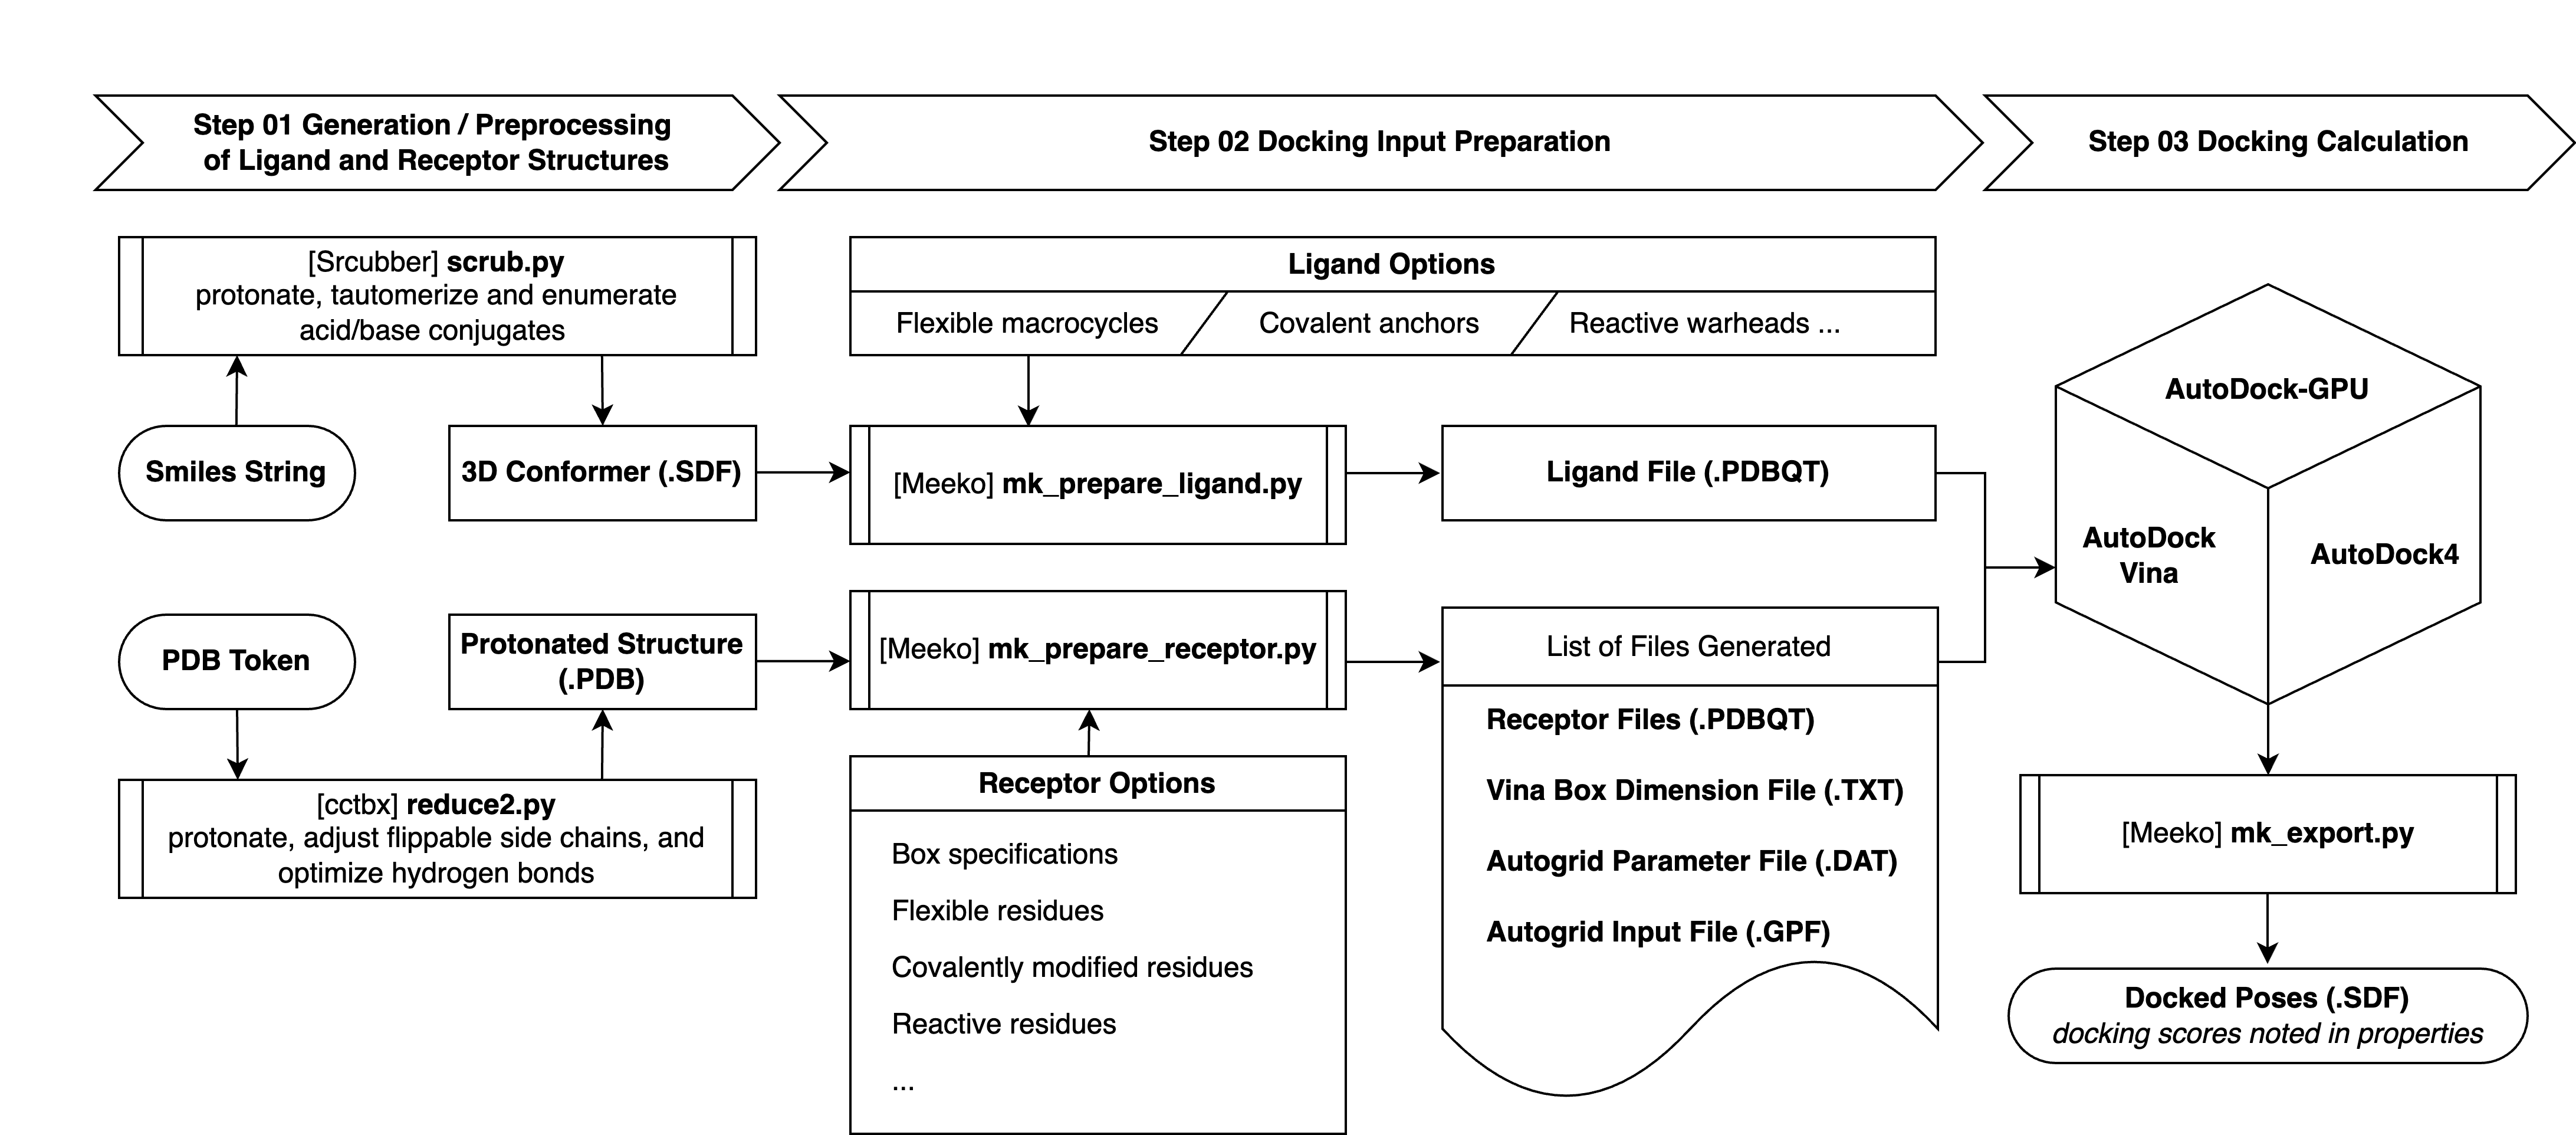


# Overview of This Example: Reactive Docking

> This Colab notebook is currently indexed in:
*   Meeko Documentation - [Colab Examples](https://meeko.readthedocs.io/en/release-doc/colab_examples.html)
*   RSD3 Training Resource - [Training Resource](https://rsd3.scripps.edu/training/)

> **Subscription is NOT required** to run these Colab examples.
>
> However, the type of runtime must be **T4 GPU** to run the docking calculation with the provided executable.

This is a **reactive docking** example that uses the AutoDock-GPU executable to generate the near-attack conformation of a small molecule and a protein receptor.

The reactive docking example is based on reactive docking method that has been developed for high-throughput virtual screenings of reactive species. This method is currently only implemented in AutoDock-GPU. In this example, a small molecule substrate (Adenosine monophosphate, PDB token AMP) is targeting at the catalytic histidine residue of a hollow protein structure of bacteria RNA 3' cyclase (PDB token 3KGD) to generate the near-attack conformation for the formation of the phosphoamide bond. A docked pose that closely resembles the original position of the ligand is expected among the top-ranked poses.

## Colab Tips

* To make an **editable copy** of this notebook: Navigate to the top menu bar, File > Save a copy.
* You must **connect to a runtime first** to execute the code blocks. Use the top menu bar to manage your runtime and sessions.
* To **execute** each code block: Use the Play button on the left.
* To see the **table of contents** and **access files in directory**: Use the left hand side panel.



# Environment Setup

In these steps, a Python environment is prepared for you to run this example.

*Major Python packages used*

- RDKit https://rdkit.org/
- Molscrub https://github.com/forlilab/molscrub
- Meeko https://github.com/forlilab/Meeko
- ProDy http://www.bahargroup.org/prody/
- cctbx-base (for reduce2) https://github.com/cctbx/cctbx_project
- py3Dmol https://3dmol.org/

*Other programs used*
- autogrid https://github.com/ccsb-scripps/AutoGrid

*Data*

- Phenix-project/geostd (for reduce2) https://github.com/phenix-project/geostd/

In [1]:
# @title (1) Install Condacolab (< 1min)
%%time

! pip install -q condacolab
import condacolab
condacolab.install()

#@markdown > An automatic restart of the kernel is expected after the execution of this block.
#@markdown >
#@markdown > Stay connected to the same runtime and proceed to the next code block!


⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:14
🔁 Restarting kernel...
CPU times: user 530 ms, sys: 173 ms, total: 704 ms
Wall time: 18.1 s


In [1]:
# @title (2) Install Packages and Data (~ 2min)
%%time

# Get environment configuration from Git Repository
setup_repo="https://github.com/rwxayheee/colab_setup"
!git clone {setup_repo}

# Run setup script
!chmod +x colab_setup/basic_setup.sh
!bash colab_setup/basic_setup.sh

Cloning into 'colab_setup'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 63 (delta 24), reused 45 (delta 16), pack-reused 0 (from 0)
Receiving objects: 100% (63/63), 11.99 KiB | 11.99 MiB/s, done.
Resolving deltas: 100% (24/24), done.

[INFO] Step 1: Installing Python packages using Conda and Pip...

Channels:
 - conda-forge
Platform: linux-64
Solving environment: \ | / - \ | / - \ | done

cctbx-base-2024.8    | 66.8 MB   | :   0% 0/1 [00:00<?, ?it/s]
pillow-11.1.0        | 40.1 MB   | :   0% 0/1 [00:00<?, ?it/s]

librdkit-2024.03.6   | 20.1 MB   | :   0% 0/1 [00:00<?, ?it/s]


scipy-1.15.1         | 18.3 MB   | :   0% 0/1 [00:00<?, ?it/s]



pandas-2.2.3         | 15.0 MB   | :   0% 0/1 [00:00<?, ?it/s]




prody-2.4.1          | 13.6 MB   | :   0% 0/1 [00:00<?, ?it/s]





icu-75.1             | 11.6 MB   | :   0% 0/1 [00:00<?, ?it/s]






matplotlib-base-3.10

In [2]:
# @title (3) Import Modules & Locate Command Line Scripts (< 1s)
%%time

# Import modules
import sys, platform
from prody import *
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import AllChem
import rdkit, py3Dmol
print("rdkit version:", rdkit.__version__)
print("py3Dmol version:", py3Dmol.__version__)
from ipywidgets import interact, IntSlider
import ipywidgets, copy
from IPython.display import display, Markdown


# Helper functions
def locate_file(from_path = None, query_path = None, query_name = "query file"):

    if not from_path or not query_path:
        raise ValueError("Must specify from_path and query_path")

    possible_path = list(from_path.glob(query_path))

    if not possible_path:
        raise FileNotFoundError(f"Cannot find {query_name} from {from_path} by {query_path}")

    return_which = (
        f"using {query_name} at:\n"
        f"{possible_path[0]}\n"
    )
    print(return_which)

    return possible_path[0]


# Commandline scripts
scrub = locate_file(from_path = Path("/usr/local/bin"), query_path = "scrub.py", query_name = "scrub.py")
mk_prepare_ligand = locate_file(from_path = Path("/usr/local/bin"), query_path = "mk_prepare_ligand.py", query_name = "mk_prepare_ligand.py")
mk_prepare_receptor = locate_file(from_path = Path("/usr/local/bin"), query_path = "mk_prepare_receptor.py", query_name = "mk_prepare_receptor.py")
mk_export = locate_file(from_path = Path("/usr/local/bin"), query_path = "mk_export.py", query_name = "mk_export.py")


# Locate reduce2 in conda install prefix
full_py_version = platform.python_version()
major_and_minor = ".".join(full_py_version.split(".")[:2])
env_path = Path("/usr/local") # default conda install prefix on Colab
reduce2_path = f"lib/python{major_and_minor}/site-packages/mmtbx/command_line/reduce2.py"
reduce2 = locate_file(from_path = env_path, query_path = reduce2_path, query_name = "reduce2.py")


# Locate geostd in current path
geostd_path = locate_file(from_path = Path.cwd(), query_path = "geostd", query_name = "geostd")

#@markdown > Version of imported modules and the location of command line scripts will be reported to output.
#@markdown >
#@markdown > Make sure there are no errors and proceed to the next code block!


rdkit version: 2024.03.6
py3Dmol version: 2.4.2
using scrub.py at:
/usr/local/bin/scrub.py

using mk_prepare_ligand.py at:
/usr/local/bin/mk_prepare_ligand.py

using mk_prepare_receptor.py at:
/usr/local/bin/mk_prepare_receptor.py

using mk_export.py at:
/usr/local/bin/mk_export.py

using reduce2.py at:
/usr/local/lib/python3.11/site-packages/mmtbx/command_line/reduce2.py

using geostd at:
/content/geostd

CPU times: user 906 ms, sys: 190 ms, total: 1.1 s
Wall time: 1.07 s


# Docking Calculation

In these steps, the exmaple docking calculation is demonstrated in a customizable setup.

*Major customizable variables*

- Ligand Smiles string: `ligand_Smiles`
- Designated pH for ligand preparation: `pH`
- Reactive atoms in the ligand: `reactive_smarts` and `reactive_smarts_idx`
- Receptor PDB ID: `pdb_token`
- ProDy selection for receptor atoms: `receptor_selection`
- ProDy selection for box enveloping: `ligand_selection`
- Specification of reactive residues and reactive atoms: `reactive_name_specific`
- Specification of target residue for covalent binding: `rec_residue`
- Size of box by padding: `padding`

In [3]:
# @title # 1.1 Ligand Preparation (< 5s)
# @markdown In this step, the ligand molecule is prepared from a Smiles string. A protonated 3D conformer of ligand is generated by **scrub.py**, and the conversion to a tangible ligand PDBQT file is done by **mk_prepare_ligand.py**.
%%time

# @markdown > Enter the Smiles string of ligand. This will be used as input for ***molscrub*** to protonate and generate a 3D conformer of the ligand.
ligand_Smiles = "c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3)COP(=O)([O-])[O-])O)O)N" #@param {type:"string"}

# @markdown > Below are some available options of ***molscrub*** to determine what protonation variants to be generated for the input ligand.

# @markdown > A designated pH is optional for this example.
pH = 6.5 #@param {type:"raw"}
# @markdown > The following two options allow you to opt out from enumeration of tautomers or protomers.
# @markdown > In this the example, we will ask ***molscrub*** to NOT perform the tautomer or acidbase enumeration for the ligand.
args = ""
skip_tautomer = True #@param {type:"boolean"}
if skip_tautomer:
  args += "--skip_tautomer "
skip_acidbase = True #@param {type:"boolean"}
if skip_acidbase:
  args += "--skip_acidbase "
# @markdown With the above specifications, a 3D conformer of the protonated ligand will be generated by **scrub.py**.
# @markdown
# @markdown The SDF file is then fed to **mk_prepare_ligand.py** to generate the ligand PDBQT file.

# Prepare ligand PDBQT
# @markdown > A SMARTS pattern is required. Together with the 1-based `reactive_smarts_idx`, they are used to locate the reactive atom in ligand.
reactive_smarts = '"COP(=O)([O-])[O-]"' #@param {type:"string"}
reactive_smarts_idx = "3" #@param {type:"string"}

# @markdown > A name for the ligand PDBQT file is required.
ligandPDBQT = "AMP.pdbqt" #@param {type:"string"}


# Write scrubbed protomer(s) and conformer(s) to SDF
ligandName = ligandPDBQT.replace(".pdbqt", "")
ligandSDF = f"{ligandName}_scrubbed.sdf"
! python {scrub} "{ligand_Smiles}" -o {ligandSDF} --ph {pH} {args}


# Prepare ligand PDBQT
! python {mk_prepare_ligand} -i {ligandSDF} --reactive_smarts {reactive_smarts} --reactive_smarts_idx {reactive_smarts_idx} -o {ligandPDBQT}


# Visualization with py3Dmol
view = py3Dmol.view()
view.addModel(open(ligandSDF, 'r').read(),'sdf')
view.zoomTo()
view.setBackgroundColor('white')
view.addStyle({'stick': {'colorscheme':'yellowCarbon'}})
view.show()


Scrub completed.
Summary of what happened:
Input molecules supplied: 1
mols processed: 1, skipped by rdkit: 0, failed: 0
nr isomers (tautomers and acid/base conjugates): 1 (avg. 1.000 per mol)
nr conformers:  1 (avg. 1.000 per isomer, 1.000 per mol)
Input molecules processed: 1, skipped: 0
PDBQT files written: 1
PDBQT files not written due to error: 0
Input molecules with errors: 0


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

CPU times: user 21.3 ms, sys: 2.57 ms, total: 23.9 ms
Wall time: 2.02 s


In [4]:
# @title # 1.2 Receptor Preparation (< 30s)
%%time
#@markdown The preparation of a rigid receptor consists of two steps. The receptor structure is first sourced from a PDB file and sent to **reduce2.py** for hydrogen addition and optimization, and then, the conversion to a tangible receptor PDBQT file is done by **mk_prepare_receptor.py**.

# @markdown > Enter the PDB ID here to source the starting structure of receptor. This PDB file will be pulled from RCSB PDB server.
# Download PDB file
pdb_token = "3kgd" #@param {type:"string"}
! curl "http://files.rcsb.org/view/{pdb_token}.pdb" -o "{pdb_token}.pdb"


# Export receptor atoms
atoms_from_pdb = parsePDB(pdb_token)
# @markdown *ProDy Options*
receptor_selection = "chain A and not water and not hetero and not resname AMP" #@param {type:"string"}
receptor_atoms = atoms_from_pdb.select(receptor_selection)
prody_receptorPDB = f"{pdb_token}_receptor_atoms.pdb"
writePDB(prody_receptorPDB, receptor_atoms)


# Add CRYST1 card (temporarily required for reduce2)
reduce_inputPDB = f"{pdb_token}_receptor.pdb"
! cat <(grep "CRYST1" "{pdb_token}.pdb") {prody_receptorPDB} > {reduce_inputPDB}


# Run reduce2
# @markdown > Use PHIL arguments to specify the tasks for reduce2. In this example, we use `approach=add add_flip_movers=True` which is equivalent to `-build` or `-flip` in the formerly standalone reduce. These arguments ask ***reduce*** to allow NQH flips and build histidines to neutral tautomers while adding hydrogens.
reduce_opts = "approach=add add_flip_movers=True" #@param {type:"string"}
! export MMTBX_CCP4_MONOMER_LIB="{geostd_path}"; python {reduce2} {reduce_inputPDB} {reduce_opts}
# Default name of reduce output...
prepare_inPDB = f"{pdb_token}_receptorFH.pdb"

#@markdown ---
#@markdown ## (2) Receptor Preparation with Meeko

# Specify ligand
#@markdown > Use ProDy selection language to specify (ligand, residue, or any) atoms for box center calculation. In this example, we choose the ligand and will use the geometric center of ligand as box center.
atoms_from_pdb = parsePDB(pdb_token)
ligand_selection = "chain A and resname AMP" #@param {type:"string"}
ligand_atoms = atoms_from_pdb.select(ligand_selection)
center_x, center_y, center_z = calcCenter(ligand_atoms)


#@markdown > Export ligand's original position to a PDB file. This is totally optional, but we will do it for visualization.
prody_ligandPDB = "LIG.pdb" #@param {type:"string"}
writePDB(prody_ligandPDB, ligand_atoms)


# Padding in each dimension
#@markdown > Set the box by the padding range (Å) around the centered object
padding = 8.0 #@param {type:"raw"}

# @markdown With the above specifications, atom selection will be made on the original PDB file in ***ProDy***. Then, a protonated structure is generated by **reduce2.py**.
# @markdown
# @markdown The PDB file is then fed to **mk_prepare_receptor.py** to generate the receptor PDBQT file.

# @markdown > Specify the reactive residue(s) and the reactive atom(s)
reactive_name_specific = '"A:309=NE2"' #@param {type:"string"}

# Specify the altloc ID to construct the receptor from if there's an altloc ID in the input file
default_altloc = "A"
# @markdown > A basename for the receptor PDBQT file is required.
# Prepare Receptor
prepare_output = "3kgd_receptorFH" #@param {type:"string"}
! python {mk_prepare_receptor} -i {prepare_inPDB} --default_altloc {default_altloc} --reactive_name_specific {reactive_name_specific} -o {prepare_output} -v -p -g --box_enveloping {prody_ligandPDB} --padding {padding}


# Visualization with py3Dmol
def Receptor3DView(receptorPDB = None, boxPDB = None, ligPDB = None):

    view = py3Dmol.view()
    view.setBackgroundColor('white')

    view.addModel(open(boxPDB, 'r').read(),'pdb')
    view.addStyle({'stick': {}})
    view.zoomTo()

    view.addModel(open(receptorPDB, 'r').read(),'pdb')
    view.addStyle({'cartoon': {'color':'spectrum', 'opacity': 0.5}})

    if ligPDB is not None:
      view.addModel(open(ligPDB, 'r').read(), 'pdb')
      view.addStyle({'hetflag': True}, {'stick': {}})

    return view

Receptor3DView(receptorPDB = prepare_inPDB, \
               boxPDB = prepare_output + '.box.pdb', \
               ligPDB = prody_ligandPDB).show()

curl: /usr/local/lib/libcurl.so.4: no version information available (required by curl)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2003k    0 2003k    0     0  3296k      0 --:--:-- --:--:-- --:--:-- 3300k


@> PDB file is found in working directory (3kgd.pdb).
@> 11804 atoms and 1 coordinate set(s) were parsed in 0.12s.


Starting /usr/local/lib/python3.11/site-packages/mmtbx/command_line/reduce2.py
on Tue Jan 28 21:10:38 2025 by root

Processing files:
-------------------------------------------------------------------------------

  Found model, 3kgd_receptor.pdb

Processing PHIL parameters:
-------------------------------------------------------------------------------

  Adding command-line PHIL:
  -------------------------
    approach=add
    add_flip_movers=True

Final processed PHIL parameters:
-------------------------------------------------------------------------------
  data_manager {
    model {
      file = "3kgd_receptor.pdb"
    }
    default_model = "3kgd_receptor.pdb"
  }
  add_flip_movers = True


Starting job
Writing model output to 3kgd_receptorFH.pdb

                       ----------Loading Model----------                       


                      ----------Adding Hydrogens----------                     

Number of hydrogen atoms added to the input model: 2560 


The followi

@> PDB file is found in working directory (3kgd.pdb).
@> 11804 atoms and 1 coordinate set(s) were parsed in 0.12s.


@> 5062 atoms and 1 coordinate set(s) were parsed in 0.05s.

Flexible residues:
chain resnum is_reactive reactive_atom
    A    309        True           NE2
reactive_flexres={'A:309'}

For reactive docking, pass the configuration file to AutoDock-GPU:
    autodock_gpu -C 1 --import_dpf 3kgd_receptorFH.reactive_config --flexres 3kgd_receptorFH_flex.pdbqt -L <ligand_filename>


Files written:
     3kgd_receptorFH_flex.pdbqt <-- flexible receptor input file
    3kgd_receptorFH_rigid.pdbqt <-- static (i.e., rigid) receptor input file
     boron-silicon-atom_par.dat <-- atomic parameters for B and Si (for autogrid)
      3kgd_receptorFH_rigid.gpf <-- autogrid input file
        3kgd_receptorFH.box.txt <-- Vina-style box dimension file
        3kgd_receptorFH.box.pdb <-- PDB file to visualize the grid box
3kgd_receptorFH.reactive_config <-- reactive parameters for AutoDock-GPU


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

CPU times: user 455 ms, sys: 45.7 ms, total: 501 ms
Wall time: 19.2 s


In [5]:
# @title # 1.3 Grid Map Computation (< 15s)
%%time
#@markdown To use AutoDock-GPU, the grid maps need to be pre-computed with autogrid4. In this additional step, the Grid Parameter File (GPF) file generated by ***Meeko*** from the previous step is used as the input for autogrid4.

! autogrid4 -p {prepare_output+'_rigid.gpf'}


       _______________________________________________________

__________//____________________________/////_________________/________
_________/__/____________/_____________/______________/_______/________
________/____/___________/_____________/______________________/________
________/____/__/_____/_/////___/////__/__////_/_///__/__////_/________
_______/______/_/_____/__/_____/_____/_/_____/_//___/_/_/____//________
_______////////_/_____/__/_____/_____/_/_____/_/______/_/_____/________
_______/______/_/____//__/___/_/_____/_/_____/_/______/_/____//________
_______/______/__////_/___///___/////___/////__/______/__////_/________

       _______________________________________________________

                                ______
                               /      \
                              /        \
                             /          \
                             \    /\    /
                              \  /  \  /
                               \/ /\ \/
         

In [6]:
# @title # 2. Docking with ADGPU (< 5s)
%%time
#@markdown In this step, the docking calculation is executed by ***ADGPU***.
#@markdown > Specifically for reactive docking, a reactive configuration file is required. It was generated in the previous step by Meeko and now passed to AutoDock-GPU by `--import_dpf`.

#@markdown > A name for the ADGPU output is required.
output_resnam = "AMP" #@param {type:"string"}
! ./adgpu --lfile {ligandPDBQT} --flexres {prepare_output+'_flex.pdbqt'} --ffile {prepare_output+'_rigid.maps.fld'} --import_dpf {prepare_output+'.reactive_config'} --resnam {output_resnam}

AutoDock-GPU version: v1.6

Running 1 docking calculation

Cuda device:                              Tesla T4
Available memory on device:               14999 MB (total: 15102 MB)

CUDA Setup time 0.157615s
(Thread 1 is setting up Job #1)

Running Job #1
    Using heuristics: (capped) number of evaluations set to 2040163
    Local-search chosen method is: ADADELTA (ad)

Rest of Setup time 0.024516s

Executing docking runs, stopping automatically after either reaching 0.15 kcal/mol standard deviation of
the best molecules of the last 4 * 5 generations, 42000 generations, or 2040163 evaluations:

Generations |  Evaluations |     Threshold    |  Average energy of best 10%  | Samples | Best Inter + Intra
------------+--------------+------------------+------------------------------+---------+-------------------
          0 |          150 |    0.17 kcal/mol |   -1.33 +/-    0.40 kcal/mol |       4 |   -1.76 kcal/mol
          5 |        65313 |    0.17 kcal/mol |   -6.26 +/-    2.20 kcal/mol 

In [7]:
# @title # 3. Export and Visualize Docked Poses (~ 1s)
%%time
#@markdown In this step, the docking output is converted to atomistic SDF by **mk_export.py**.

# @markdown > By default, if the docking calculation was performed in AD-GPU, only the cluster lead poses will be written to the output. You may use the `--all_dlg_poses` option to preserve all generated docking poses from AD-GPU.
args = ""
all_dlg_poses = False #@param {type:"boolean"}
if all_dlg_poses:
  args += "--all_dlg_poses "

# Export Docked Poses
#@markdown > A name for the result SDF file is required.
dock_outSDF = "3kgd_AMP_adgpu_out.sdf" #@param {type:"string"}
! python {mk_export} {output_resnam}.dlg -s {dock_outSDF} {args}

#@markdown > Finally (and optionally) for visualization:
#@markdown >
#@markdown > The ***Py3DMol*** view will include object from the following files and specs:
# Previously Generated Receptor Files
receptorPDB = "3kgd_receptorFH.pdb" #@param {type:"string"}
boxPDB = "3kgd_receptorFH.box.pdb" #@param {type:"string"}
refligPDB = 'LIG.pdb' #@param {type:"string"}
reflig_resn = 'AMP' #@param {type:"string"}

# Visualize Docked Poses
def Complex3DView(view, ligmol = None, refligPDB = None, reflig_resn = None):

    new_viewer = copy.deepcopy(view)

    mblock = Chem.MolToMolBlock(ligmol)
    new_viewer.addModel(mblock, 'mol')
    new_viewer.addStyle({'hetflag': True}, {"stick": {'colorscheme': 'greenCarbon'}})

    if refligPDB is not None and reflig_resn is not None:
      new_viewer.addModel(open(refligPDB, 'r').read(), 'pdb')
      new_viewer.addStyle({'resn': reflig_resn}, {"stick": {'colorscheme': 'magentaCarbon', 'opacity': 0.8}})

    return new_viewer


confs = Chem.SDMolSupplier(dock_outSDF)

def conf_viewer(idx):
    mol = confs[idx]
    return Complex3DView(Receptor3DView(receptorPDB = receptorPDB, boxPDB = boxPDB), \
                         mol, \
                         refligPDB = refligPDB, reflig_resn = reflig_resn).show()


interact(conf_viewer, idx=ipywidgets.IntSlider(min=0, max=len(confs)-1, step=1))

interactive(children=(IntSlider(value=0, description='idx', max=0), Output()), _dom_classes=('widget-interact'…

CPU times: user 44 ms, sys: 8.91 ms, total: 52.9 ms
Wall time: 1.35 s


<function __main__.conf_viewer(idx)>

In [8]:
# Download Zipped Output
! mkdir output; cp * output
! zip -r output.zip output

cp: -r not specified; omitting directory 'colab_setup'
cp: -r not specified; omitting directory 'geostd'
cp: -r not specified; omitting directory 'output'
cp: -r not specified; omitting directory 'sample_data'
  adding: output/ (stored 0%)
  adding: output/3kgd_receptorFH_rigid.I.map (deflated 57%)
  adding: output/3kgd_receptorFH_rigid.pdbqt (deflated 76%)
  adding: output/3kgd_receptorFH.reactive_config (deflated 89%)
  adding: output/3kgd_receptor_atoms.pdb (deflated 74%)
  adding: output/3kgd_receptorFH_rigid.d.map (deflated 73%)
  adding: output/3kgd_receptor.pdb (deflated 74%)
  adding: output/3kgd_receptorFH_rigid.gpf (deflated 70%)
  adding: output/3kgd_receptorFH_rigid.BR.map (deflated 58%)
  adding: output/3kgd_receptorFH_rigid.N.map (deflated 59%)
  adding: output/3kgd_receptorFH.box.pdb (deflated 79%)
  adding: output/AMP_scrubbed.sdf (deflated 75%)
  adding: output/3kgd_receptorFH_rigid.Cl.map (deflated 58%)
  adding: output/3kgd_receptorFH_rigid.S.map (deflated 58%)
  add